In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
# Load policies dataset
with open(r'policies.json') as f:
    policies = json.load(f)
    
    print(json.dumps(policies, indent=4))

{
    "companies": [
        {
            "company_name": "Salesforce",
            "policies": [
                {
                    "id": "q1",
                    "question": "What is Salesforce's commitment to human rights?",
                    "answer": "Salesforce is committed to respecting human rights across its business and value chain, informed by the International Bill of Human Rights, the UN Guiding Principles on Business and Human Rights, and the OECD Guidelines for Multinational Enterprises. Salesforce engages with governments, partners, and civil society to support human rights.",
                    "topic": "Human Rights Commitment",
                    "tags": [
                        "human rights",
                        "commitment",
                        "values",
                        "principles"
                    ]
                },
                {
                    "id": "q2",
                    "question": "How does Salesforce implement huma

In [3]:
# Populate train_texts from your policies data
train_texts = []  # Initialize an empty list
for company in policies.get("companies", []):
    for policy in company.get("policies", []):
        question = policy.get("question", "")
        answer = policy.get("answer", "")
        if question and answer:  # Only add if both question and answer exist
            train_texts.append(question + " " + answer)


In [4]:
# Ensure that train_texts is not empty
if not train_texts:
    raise ValueError("train_texts is empty, check your policy data.")

In [5]:
# Split the dataset into training and testing sets
train_texts, test_texts = train_test_split(train_texts, test_size=0.2, random_state=42)

In [6]:
# Tokenization
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set the pad token to be the same as the eos token



# Tokenize training and testing texts
train_encodings = tokenizer('\n'.join(train_texts), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer('\n'.join(test_texts), truncation=True, padding=True, return_tensors='pt')


# Create a custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = item['input_ids']  # Set labels to input_ids for next-token prediction
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create the datasets
train_dataset = CustomDataset(train_encodings)
test_dataset = CustomDataset(test_encodings)

In [7]:
# Load the GPT-2 model
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [8]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',           # Directory to save the model
    num_train_epochs=5,               # Number of training epochs
    per_device_train_batch_size=2,    # Batch size for training
    save_steps=10_000,                # Save checkpoint every 10,000 steps
    save_total_limit=2,               # Keep only the last 2 checkpoints
    logging_dir='./logs',             # Directory for logging
)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# Train the model
trainer.train()

# Save the model and tokenizer
trainer.save_model("1_trained_gpt2")
tokenizer.save_pretrained("1_trained_gpt2")


  0%|          | 0/5 [00:00<?, ?it/s]

{'train_runtime': 61.2091, 'train_samples_per_second': 0.082, 'train_steps_per_second': 0.082, 'train_loss': 2.6575618743896485, 'epoch': 5.0}


('1_trained_gpt2\\tokenizer_config.json',
 '1_trained_gpt2\\special_tokens_map.json',
 '1_trained_gpt2\\vocab.json',
 '1_trained_gpt2\\merges.txt',
 '1_trained_gpt2\\added_tokens.json')

In [15]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Load model and tokenizer from the saved folder
model_path = r"C:\Users\Suyash Tambe\Desktop\Chatbot\trained_gpt2"  # Replace with actual model folder path
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)
model.eval()

# Set pad_token_id and attention mask
tokenizer.pad_token = tokenizer.eos_token
pad_token_id = tokenizer.pad_token_id

# Define sample test questions and expected answers
test_texts = [
    "What are the employee rights?",
    "What is the corporate responsibility policy?",
    "How does the company ensure ethical standards?"
]

expected_answers = [
    "Employee rights include fair compensation, privacy, and safe working conditions.",
    "Corporate responsibility involves environmental sustainability and community engagement.",
    "The company ensures ethical standards through strict compliance policies and regular training."
]

predictions = []

# Generate predictions for test samples
with torch.no_grad():
    for text in test_texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        inputs["attention_mask"] = (inputs["input_ids"] != pad_token_id).long()
        
        outputs = model.generate(**inputs, max_length=100, pad_token_id=pad_token_id)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        predictions.append(prediction)

# Calculate BLEU scores
bleu_scores = []
smoothing = SmoothingFunction().method4  # Smooth for short sentences

for i, prediction in enumerate(predictions):
    reference = expected_answers[i].split()  # Tokenize the reference answer
    candidate = prediction.split()  # Tokenize the generated answer
    bleu_score = sentence_bleu([reference], candidate, smoothing_function=smoothing)
    bleu_scores.append(bleu_score)

# Print BLEU scores for each prediction
for i, question in enumerate(test_texts):
    print(f"Question: {question}")
    print(f"Prediction: {predictions[i]}")
    print(f"Expected: {expected_answers[i]}")
    print(f"BLEU Score: {bleu_scores[i]:.4f}\n")

# Optional: Calculate average BLEU score across all samples
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu:.4f}")


Question: What are the employee rights?
Prediction: What are the employee rights?

Employees are entitled to a fair and reasonable wage, benefits, and other benefits. Employees are entitled to reasonable accommodations, including reasonable accommodations for personal needs, including reasonable accommodations for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for personal needs for
Expected: Employee rights include fair compensation, privacy, and safe working conditions.
BLEU Score: 0.0043

Question: What is the corporate responsibility policy?
Prediction: What is the corporate responsibility policy?

The corporate responsibility policy is a policy that requires companies to provide a minimum of fin

In [ ]:

# Load model and tokenizer from the saved folder
model_path = r"C:\Users\Suyash Tambe\Desktop\Chatbot\trained_gpt2"  
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)
model.eval()

# Set pad_token_id and attention mask
tokenizer.pad_token = tokenizer.eos_token
pad_token_id = tokenizer.pad_token_id

# Define sample test questions and expected answers as labels (simplified for classification)
test_texts = [
    "What are the employee rights?",
    "What is the corporate responsibility policy?",
    "How does the company ensure ethical standards?"
]

expected_answers = [
    "Employee rights include fair compensation, privacy, and safe working conditions.",
    "Corporate responsibility involves environmental sustainability and community engagement.",
    "The company ensures ethical standards through strict compliance policies and regular training."
]

# Define classes based on expected answers
classes = ["Rights", "Responsibility", "Ethics"]
predicted_labels = []
actual_labels = []

# Generate predictions and classify based on keyword matching
smoothing = SmoothingFunction().method4  # Smoothing for short sentences

with torch.no_grad():
    for i, text in enumerate(test_texts):
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        inputs["attention_mask"] = (inputs["input_ids"] != pad_token_id).long()
        
        outputs = model.generate(**inputs, max_length=100, pad_token_id=pad_token_id)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Classify generated text based on keyword matching
        if "rights" in prediction.lower():
            predicted_labels.append("Rights")
        elif "responsibility" in prediction.lower():
            predicted_labels.append("Responsibility")
        elif "ethics" in prediction.lower():
            predicted_labels.append("Ethics")
        else:
            predicted_labels.append("Unknown")  # Default for unmatched cases
        
        # Append actual labels based on expected answers
        actual_labels.append(classes[i])

# Print classification report
print("Classification Report:\n", classification_report(actual_labels, predicted_labels, zero_division=1))


Classification Report:
                 precision    recall  f1-score   support

        Ethics       1.00      0.00      0.00         1
Responsibility       1.00      1.00      1.00         1
        Rights       1.00      1.00      1.00         1
       Unknown       0.00      1.00      0.00         0

      accuracy                           0.67         3
     macro avg       0.75      0.75      0.50         3
  weighted avg       1.00      0.67      0.67         3



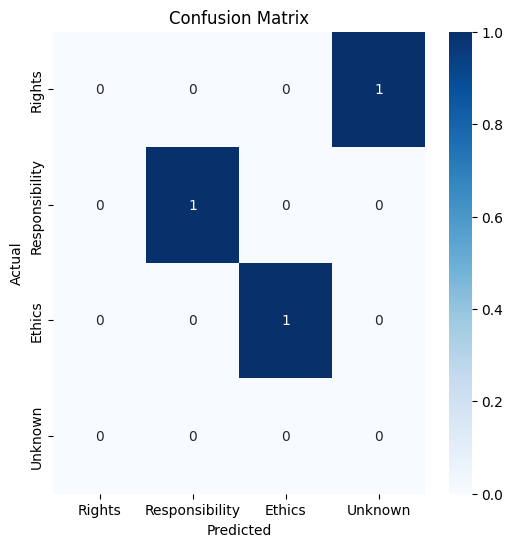

In [21]:
# Generate and print confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes + ["Unknown"], 
            yticklabels=classes + ["Unknown"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

True labels shape: (278,)
Predictions shape: (278,)


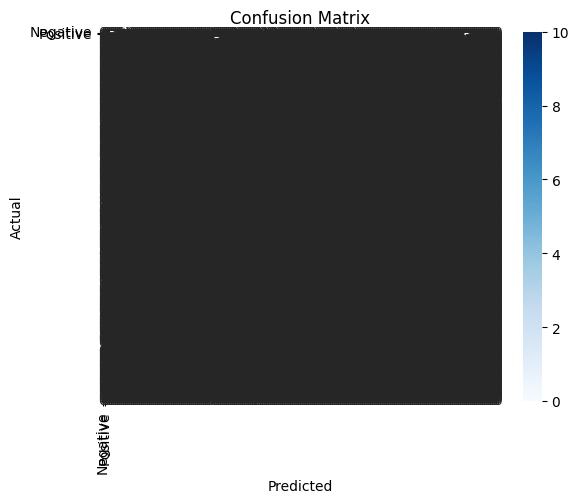

Classification Report:


ValueError: Number of classes, 198, does not match size of target_names, 2. Try specifying the labels parameter

In [34]:
# Evaluation
model.eval()  # Set model to evaluation mode
true_labels = []
predictions = []

# Collect true labels and predictions
with torch.no_grad():
    for idx in range(len(test_dataset)):
        batch = test_dataset[idx]
        input_ids = batch['input_ids'].unsqueeze(0)  # Add batch dimension
        attention_mask = batch['attention_mask'].unsqueeze(0)

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=-1).cpu().numpy()

        true_labels.extend(batch['labels'].cpu().numpy().flatten())  # Flatten true labels
        predictions.extend(predicted_labels.flatten())  # Flatten predictions

# Convert to numpy arrays for metrics calculation
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Check shapes
print(f'True labels shape: {true_labels.shape}')
print(f'Predictions shape: {predictions.shape}')

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=['Negative', 'Positive']))

# ROC Curve and AUC
# Calculate ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
